In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
import plotly.express as px
from dotenv import load_dotenv
import json
from collections import defaultdict
import importlib
import warnings
warnings.filterwarnings('ignore')
import utils
importlib.reload(utils)
import os
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from scipy.optimize import differential_evolution
from scipy.stats import skewnorm

In [104]:
def load_weather(weather_path, obs_year):    
    # Load the "Hourly" weather data
    
    weather_data = pd.read_csv(weather_path)
    # Slicing the weather data to the dates within the observation year
    weather_data['Date'] = pd.to_datetime(weather_data['Date'], errors='coerce')
    weather_data = weather_data[
        (weather_data['Date'] >= pd.to_datetime(f'1/1/{obs_year}')) &
        (weather_data['Date'] <= pd.to_datetime(f'31/12/{obs_year}'))]     
    # Renaming the columns and add doy column         
    weather_data = weather_data[['Date', 'Time', 'Air Temp. (°C)']].rename(columns={'Date': 'date', 'Time':'Time', 'Air Temp. (°C)':'temp'}, inplace=False)
    weather_data.insert(1, 'doy', [d.dayofyear for d in pd.to_datetime(weather_data['date'], format="mixed")])
    # Interpolate missing values
    # Convert '-' to NaN
    weather_data['temp'].replace('-', np.nan, inplace=True)
    weather_data['temp']=weather_data['temp'].apply(pd.to_numeric, errors='coerce')

    # Interpolate missing values
    if weather_data['temp'].isna().any():
        weather_data['temp'].interpolate(method='linear', inplace=True)


    return weather_data.reset_index(drop=True) 


In [105]:
# Load datasets for observations
def load_observations(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location, excel_observs_BB, excel_observs_Flwr, spray_col_name):
    
    # Define the expected column names for the final concatenated DataFrame
    TREATMENT = "Treatment"
    LOCATION = "Location"
    xls = pd.ExcelFile(file_path, engine="openpyxl")
    raw_df_BB = pd.read_excel(xls, sheet_name = BB_sheet_name)
    raw_df_Flwr = pd.read_excel(xls, sheet_name = Flwr_sheet_name)

    # Rename the Dates to Days of Year (DOY)
    doy_column_BB = [pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)]
    df_BB = raw_df_BB.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)})

    doy_column_Flwr = [pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)]
    df_Flwr = raw_df_Flwr.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)})

    obs_year = [pd.to_datetime(col).year for col in raw_df_BB.columns if utils.is_date_column(col)][0]


    # Apply filtering for the given cultivar & treatments
    def filter_df(df, doy_column, spray_col_name):
        filtered_df = df[df[cultivar_col].isin([cultivar_name]) & df[treatment_col].isin([treatment_name])]
        # Rename columns
        columns_to_select = [treatment_col] + [spray_col_name] + doy_column 
        filtered_df = filtered_df[columns_to_select]
        filtered_df.rename(columns={treatment_col: TREATMENT}, inplace=True)
        # Add the LOCATION column to the DataFrame
        filtered_df[LOCATION] = location
        # Remove rows with any NaN values
        filtered_df = filtered_df.dropna()
        # Reset index 
        filtered_df.reset_index(drop=True)
        return filtered_df
    filtered_df_BB = filter_df(df_BB,doy_column_BB, spray_col_name)

    filtered_df_Flwr = filter_df(df_Flwr,doy_column_Flwr, spray_col_name)

    # Spray date(s)
    application_dates = filtered_df_BB[spray_col_name].unique()

    BudBurstDOYs = []
    FlwrDOYs = []
    for spray_date in application_dates:
        # find the budburst doy for each application date
        filtered_df_BB_spray = filtered_df_BB[filtered_df_BB[spray_col_name].isin([spray_date])]
        BB_percent = False
        PBB, BB, BudBurstDOY, max_observed_buds = utils.BB_specifications(location,filtered_df_BB_spray[doy_column_BB],BB_percent)
        BudBurstDOYs.append(int(BudBurstDOY))
        maxBBPsequence = np.empty(len(doy_column_BB))*np.nan
        maxBBPsequence[-1] = np.max(PBB)

        # Corresponding stage name (StartFlowering) to get the max BBP 
        MaxBBPstageSequence = [np.nan for i in range(len(doy_column_BB))]
        MaxBBPstageSequence[-1] = 'StartFlowering'


        # Generate the observations Excel file for Budbreak
        excel_observ_BB = pd.DataFrame(data={
        'SimulationName': f'{BB_sheet_name}{filtered_df_BB_spray[TREATMENT].iloc[0].replace(" ", "")}', 
                                            'Clock.Today': [col for col in raw_df_BB.columns if utils.is_date_column(col)],
                                            'Clock.Today.Year': obs_year,
                                            'DOY': doy_column_BB, 
                                            LOCATION: filtered_df_BB_spray[LOCATION].iloc[0], 
                                            TREATMENT: filtered_df_BB_spray[TREATMENT].iloc[0],
                                            'KiwiFruit.Phenology.BrokenBuds': BB,
                                            'KiwiFruit.Phenology.ProportionBB': PBB,
                                            'KiwiFruit.Phenology.BudBurstDOY': BudBurstDOY,
                                            'KiwiFruit.Phenology.MaxBBP': maxBBPsequence,
                                            'KiwiFruit.Phenology.CurrentStageName': MaxBBPstageSequence})
        
        FlwrDOY, Flowers = utils.Flwr_specifications(np.max(BB),filtered_df_Flwr[doy_column_Flwr])
        FlwrDOYs.append(int(FlwrDOY))
        maxFlwrsequence = np.empty(len(doy_column_Flwr))*np.nan
        maxFlwrsequence[-1] = FlwrDOY

        # Corresponding stage name (StartFlowering) to get the max BBP 
        MaxFlwrstageSequence = [np.nan for i in range(len(doy_column_Flwr))]
        MaxFlwrstageSequence[-1] = 'StartFlowering'

        # Generate the observations Excel file for Flowering
        excel_observ_Flwr = pd.DataFrame(data={
        'SimulationName': f'{BB_sheet_name}{filtered_df_BB[TREATMENT].iloc[0].replace(" ", "")}',  # Use same BB sheet name to be able to put in same apsim simulation
                                            'Clock.Today': [col for col in raw_df_Flwr.columns if utils.is_date_column(col)],
                                            'Clock.Today.Year': obs_year,
                                            'DOY': doy_column_Flwr, 
                                            LOCATION: filtered_df_Flwr[LOCATION].iloc[0], 
                                            TREATMENT: filtered_df_Flwr[TREATMENT].iloc[0],
                                            'KiwiFruit.Phenology.Flowers': Flowers,
                                            'KiwiFruit.Phenology.FloweringDOY': FlwrDOY,
                                            'KiwiFruit.Phenology.CurrentStageName': MaxFlwrstageSequence})
        
        excel_observs_BB.append(excel_observ_BB)
        excel_observs_Flwr.append(excel_observ_Flwr)

    return obs_year, application_dates, PBB, BB, BudBurstDOYs, FlwrDOYs, excel_observs_BB, excel_observs_Flwr
    


In [106]:
with open("config_MultiDataFiles_HC.json", "r") as file:
    config = json.load(file)
base_model_config = utils.base_model_config()
start_doy = pd.to_datetime(base_model_config["StartDay"]).dayofyear

predicted_endo_release_doy = defaultdict(lambda: defaultdict(lambda: dict()))
predicted_budbreak_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_budbreak_doy = defaultdict(lambda: defaultdict(lambda: dict()))
predicted_flowering_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_flowering_doy = defaultdict(lambda: defaultdict(lambda: dict()))
observed_application_doy = defaultdict(lambda: defaultdict(lambda: dict()))
weather_df = defaultdict(lambda: defaultdict(lambda: dict()))
excel_observs_BB = []
excel_observs_Flwr = []
output_excel = 'HC_Observations.xlsx'

# Load environment variables
load_dotenv()
FOLDER_PATH = os.getenv('FOLDER_PATH')
for file_name, file_info in config.items():
        file_path = os.path.join(FOLDER_PATH, file_name)
        # Process each sheet
        for sheet_info in file_info['sheets']:
            # Extract sheet names, cultivars, and treatments
            BB_sheet_name = sheet_info['BB_sheet_name']
            Flwr_sheet_name = sheet_info['Flwr_sheet_name']
            location = sheet_info['location']
            spray_col_name = sheet_info['spray']
            cultivar_col, cultivar_name = list(sheet_info['cultivar'].items())[0]
            treatment_col, treatment_name = list(sheet_info['treatments'].items())[0]

            # Load and calculate the observed budburst doy
            obs_year, application_dates, PBB, BB, BudBurstDOYs, Flwr_DOYs, excel_observs_BB, excel_observs_Flwr  = load_observations(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location,excel_observs_BB, excel_observs_Flwr,spray_col_name)
            for spray_date,BudBurstDOY,Flwr_DOY in zip(application_dates,BudBurstDOYs,Flwr_DOYs):
                observed_budbreak_doy[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = BudBurstDOY
                observed_flowering_doy[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = Flwr_DOY
                observed_application_doy[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = pd.to_datetime(spray_date).dayofyear

                # Load and store the weather data
                weather_path = sheet_info['weather_path']
                weather_data = load_weather(weather_path, obs_year)
                weather_df[location][obs_year][BB_sheet_name+treatment_name+str(pd.to_datetime(spray_date).dayofyear)] = weather_data




In [107]:
def Chill(Tc, T):
    if T>=0 and T <= Tc:
        return (((4*T)/(Tc**2))*(Tc-T))
    else:
        return 0
    
def Wangengel(MinTemp,OptTemp,MaxTemp,RefTemp,T):
    RelEff = 0.0
    RelEffRefTemp = 1.0
    p = 0.0

    if MinTemp < T < MaxTemp:
        p = math.log(2.0) / math.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEff = (2 * (T - MinTemp) ** p * (OptTemp - MinTemp) ** p - (T - MinTemp) ** (2 * p)) / (OptTemp - MinTemp) ** (2 * p)

    if MinTemp < RefTemp < MaxTemp:
        p = math.log(2.0) / math.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEffRefTemp = (2 * (RefTemp - MinTemp) ** p * (OptTemp - MinTemp) ** p - (RefTemp - MinTemp) ** (2 * p)) / (OptTemp - MinTemp) ** (2 * p)

    return float(RelEff / RelEffRefTemp)


def logistic_scaling(app_units, ideal_units,max_effect_low, max_effect_high, steepness):
    distance = app_units - ideal_units
    scale = 1 / (1 + np.exp(-steepness * distance))
    max_effect = max_effect_low + scale * (max_effect_high - max_effect_low)
    return max_effect

def linear_scaling(app_units, ideal_units, max_effect_high, max_effect_low,  tolerance):
    # Linear scaling of max_effect depending on distance from ideal_doy
    distance = abs(app_units - ideal_units)
    scale = min(distance / tolerance, 1)  # cap at 1 to avoid over-scaling
    max_effect = max_effect_low + scale * (max_effect_high - max_effect_low)
    return max_effect

def quadratic_scaling(app_units, ideal_units, max_effect_high, max_effect_low,  tolerance):
    # Linear scaling of max_effect depending on distance from ideal_doy
    distance = abs(app_units - ideal_units)
    scale = min(distance / tolerance, 1) ** 2 # cap at 1 to avoid over-scaling
    max_effect = max_effect_low + scale * (max_effect_high - max_effect_low)
    return max_effect

def hi_cane_effective_chill_target(ideal_units, max_effect_high, max_effect_low,  tolerance, app_units, base_chill_target):
    """
    Adjusts effective chill target based on timing of Hi-Cane application and 
    a linearly scaled max effect that varies with application units (app_units) relative to ideal window.
    
    Parameters:
    - ideal_units: target accumulated units where Hi-Cane is most effective
    - max_effect_high: effect when applied far from ideal (e.g. early/late)
    - max_effect_low: effect when applied near the ideal time
    - tolerance: spread of the Gaussian curve
    - app_units: accumulated chill units at application
    - base_chill_target: baseline chill requirement without Hi-Cane
        
    Returns:
        adjusted chill target based on application timing
    """
    Guassian = np.exp(-0.5 * ((app_units - ideal_units) / tolerance) ** 2)

    # linear scaling:
    max_effect = quadratic_scaling(app_units, ideal_units, max_effect_high, max_effect_low, tolerance)
    # logistic scaling:
    # max_effect = logistic_scaling(app_units, ideal_units,max_effect_low, max_effect_high, steepness)

    effect = 1 - max_effect * Guassian

    effective_chill_target = base_chill_target * effect

    return effective_chill_target

def skewed_gaussian_effect(Acc_unit_spray, max_effect, center, width, skew, base_chill_target):
    skewed_Guassian =  skewnorm.pdf(Acc_unit_spray - center, a=skew, scale=width) 
    effect = 1 - max_effect * skewed_Guassian
    effective_chill_target = base_chill_target * effect

    return effective_chill_target


# Calculate Acc. Chill+Heat units on Spray Date

In [ ]:
CHU_spray = defaultdict(lambda: defaultdict(lambda: dict()))
CHU_observation = defaultdict(lambda: defaultdict(lambda: dict()))


start_day = int(round(pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year))

for location in observed_application_doy.keys():
    for year in observed_application_doy[location].keys():
        for sheet_info, weather_data in weather_df[location][year].items():
            application_doy = observed_application_doy[location][year][sheet_info]
            observation_doy = observed_budbreak_doy[location][year][sheet_info]
            weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
            
            # Chill & heat accumulation on Spray Date
            chillVal = 0
            heatVal = 0
            for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                chillVal += Chill( base_model_config['Tc_chill'], temp)
                if chillVal <= base_model_config['ChillRequirement'] and weather_since_start_doy['doy'].iloc[idx_endodormancy_release] == application_doy:
                        CHU_spray[location][year][sheet_info] = chillVal 
                        break 
                    
                elif chillVal >= base_model_config['ChillRequirement'] and weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < application_doy:
                    for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                        heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)                       
                        if weather_since_start_doy['doy'].iloc[idx_bb] == application_doy and heatVal < base_model_config['HeatRequirement']:                        
                            CHU_spray[location][year][sheet_info] = base_model_config['ChillRequirement'] + heatVal
                            break 
                        elif weather_since_start_doy['doy'].iloc[idx_bb] < application_doy and heatVal >= base_model_config['HeatRequirement']:
                            CHU_spray[location][year][sheet_info] = base_model_config['ChillRequirement'] + base_model_config['HeatRequirement']
                            break 


            # Chill & heat accumulation on Observation Date
            chillVal = 0
            heatVal = 0
            for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                chillVal += Chill( base_model_config['Tc_chill'], temp)
                if chillVal <= base_model_config['ChillRequirement'] and weather_since_start_doy['doy'].iloc[idx_endodormancy_release] == observation_doy:
                        CHU_observation[location][year][sheet_info] = chillVal 
                        break 
                    
                elif chillVal >= base_model_config['ChillRequirement'] and weather_since_start_doy['doy'].iloc[idx_endodormancy_release] < observation_doy:
                    for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                        heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)                       
                        if weather_since_start_doy['doy'].iloc[idx_bb] == observation_doy or heatVal>= base_model_config['HeatRequirement'] :
                            CHU_observation[location][year][sheet_info] = base_model_config['ChillRequirement'] + heatVal
                            break 
    



# Optimization (CU Gaussian)

In [ ]:
def objective_function(params, locations, weather_df, observed_budbreak_doy): 
    ideal_spray_units, max_effect_high ,max_effect_low, tolerance = params
    chill_start_day = pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year 
    
    predictions = []
    observed = []
    for i, location in enumerate(locations): # locations = ['Te Puke', 'Kerikeri']
        start_day = int(round(chill_start_day))
        for year, sheet_info in weather_df[location].items(): 
            for sheet_info, weather_data in weather_df[location][year].items():
                weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
                

                predicted_doy = 365  # Default value if  target not reached

                Acc_unit_spray = CHU_spray[location][year][sheet_info]

                effective_target = hi_cane_effective_chill_target(ideal_spray_units, max_effect_high , max_effect_low, tolerance, Acc_unit_spray, base_model_config['ChillRequirement']+ base_model_config['HeatRequirement'])
 
                effective_chill_target = (base_model_config['ChillRequirement']/(base_model_config['ChillRequirement']+base_model_config['HeatRequirement'])) * effective_target
                effective_heat_target =  effective_target - effective_chill_target
                    


                # Chill accumulation
                chillVal = 0
                for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                    chillVal += Chill( base_model_config['Tc_chill'], temp)
                    if chillVal >= effective_chill_target:
                        break

                # Heat accumulation
                # from the date of endodormancy release, start accumulating heat
                heatVal = 0
                for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                    heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)
                    if heatVal >= effective_heat_target:
                        predicted_doy = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release + idx_bb + 1])
                        break

                predictions.append(predicted_doy)
                observed.append(observed_budbreak_doy[location][year][sheet_info])

    return mean_absolute_error(observed, predictions)

# Define a wrapper function that takes both params and fixed args
def wrapped_objective(params):
    return objective_function(params, ['Te Puke', 'Kerikeri'], weather_df, observed_budbreak_doy)



bounds = [
    (1000,1500), # ideal_spray_units
    (0.01,0.1),  # max_effect_high
    (0.1, 0.7), # max_effect_low
    # (0.001,0.2),  # steepness
    (50,500)] # tolerance (in chill/heat units)


result = differential_evolution(
    func=wrapped_objective,
    bounds=bounds,
    strategy='best1bin',
    popsize=10,
    maxiter=500)

In [91]:
result.x

array([1.00509777e+03, 9.35180554e-02, 2.72600105e-01, 4.92979815e+02])

In [ ]:
# Evenly spread: [1.57826822e+03, 1.50032962e-01, 2.02592672e-01, 1.25898305e+02]

# Least MAE but uneven: [1.00509777e+03, 9.35180554e-02, 2.72600105e-01, 4.92979815e+02]

In [100]:
locations = ['Te Puke', 'Kerikeri']
chill_start_day = pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year 
ideal_spray_units = result.x[0]
max_effect_high = result.x[1]
max_effect_low = result.x[2]
# steepness = result.x[3]
tolerance = result.x[3]

predicted_budbreak_doy = defaultdict(lambda: defaultdict(lambda: defaultdict()))

for i, location in enumerate(locations):
    start_day = int(round(chill_start_day))
    for year, sheet_info in weather_df[location].items(): 
        for sheet_info, weather_data in weather_df[location][year].items():
            weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
            
            Acc_unit_spray = CHU_spray[location][year][sheet_info]

            app_doy = observed_application_doy[location][year][sheet_info]
            effective_target = hi_cane_effective_chill_target(ideal_spray_units, max_effect_high , max_effect_low, tolerance, Acc_unit_spray, base_model_config['ChillRequirement']+base_model_config['HeatRequirement'])

            effective_chill_target = (base_model_config['ChillRequirement']/(base_model_config['ChillRequirement']+base_model_config['HeatRequirement'])) * effective_target
            effective_heat_target = effective_target - effective_chill_target


            # Chill accumulation
            chillVal = 0
            for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                chillVal += Chill( base_model_config['Tc_chill'], temp)
                if chillVal >= effective_chill_target:
                    break

            # Heat accumulation
            # from the date of endodormancy release, start accumulating heat
            heatVal = 0
            for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)
                if heatVal >= effective_heat_target:
                    predicted_doy = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release + idx_bb + 1])
                    break

            predicted_budbreak_doy[location][year][sheet_info] = predicted_doy

# Optimization (CU Skewed Gaussian)

In [ ]:
def objective_function(params, locations, weather_df, observed_budbreak_doy): 
    ideal_spray_units, max_effect, tolerance, skew = params
    chill_start_day = pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year 
    
    predictions = []
    observed = []
    for i, location in enumerate(locations): # locations = ['Te Puke', 'Kerikeri']
        start_day = int(round(chill_start_day))
        for year, sheet_info in weather_df[location].items(): 
            for sheet_info, weather_data in weather_df[location][year].items():
                weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
                

                predicted_doy = 365  # Default value if  target not reached

                Acc_unit_spray = CHU_spray[location][year][sheet_info]

                effective_target = skewed_gaussian_effect(Acc_unit_spray, max_effect, ideal_spray_units, tolerance, skew, base_model_config['ChillRequirement']+base_model_config['HeatRequirement'])

                effective_chill_target = (base_model_config['ChillRequirement']/(base_model_config['ChillRequirement']+base_model_config['HeatRequirement'])) * effective_target
                effective_heat_target =  effective_target - effective_chill_target
                    


                # Chill accumulation
                chillVal = 0
                for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                    chillVal += Chill( base_model_config['Tc_chill'], temp)
                    if chillVal >= effective_chill_target:
                        break

                # Heat accumulation
                # from the date of endodormancy release, start accumulating heat
                heatVal = 0
                for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                    heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)
                    if heatVal >= effective_heat_target:
                        predicted_doy = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release + idx_bb + 1])
                        break

                predictions.append(predicted_doy)
                observed.append(observed_budbreak_doy[location][year][sheet_info])

    # weighted mse to emphasize on the extremes
    # weights = np.abs(predictions - np.median(observed))
    # mse_weighted = np.average((np.array(predictions) - np.array(observed))**2, weights=weights)


    return mean_absolute_error(observed, predictions)

# Define a wrapper function that takes both params and fixed args
def wrapped_objective(params):
    return objective_function(params, ['Te Puke', 'Kerikeri'], weather_df, observed_budbreak_doy)



bounds = [
    (800,1300), # ideal_spray_units
    (10,1000),  # max_effect
    (100,400), # tolerance (in chill/heat units)
    (-10,10)] # skew


result = differential_evolution(
    func=wrapped_objective,
    bounds=bounds,
    strategy='best1bin',
    popsize=10,
    maxiter=500)

In [ ]:
result.x

In [ ]:
locations = ['Te Puke', 'Kerikeri']
chill_start_day = pd.to_datetime(utils.base_model_config()['StartDay']).day_of_year 
ideal_spray_units = result.x[0]
max_effect = result.x[1]
tolerance = result.x[2]
skew = result.x[3]

predicted_budbreak_doy = defaultdict(lambda: defaultdict(lambda: defaultdict()))

for i, location in enumerate(locations):
    start_day = int(round(chill_start_day))
    for year, sheet_info in weather_df[location].items(): 
        for sheet_info, weather_data in weather_df[location][year].items():
            weather_since_start_doy = weather_data[weather_data['doy']>=start_day].reset_index(drop=True)  
            
            Acc_unit_spray = CHU_spray[location][year][sheet_info]

            app_doy = observed_application_doy[location][year][sheet_info]
            effective_target = skewed_gaussian_effect(Acc_unit_spray, max_effect, ideal_spray_units, tolerance, skew, base_model_config['ChillRequirement']+ base_model_config['HeatRequirement'])

            effective_chill_target = (base_model_config['ChillRequirement']/(base_model_config['ChillRequirement']+base_model_config['HeatRequirement'])) * effective_target
            effective_heat_target = effective_target - effective_chill_target


            # Chill accumulation
            chillVal = 0
            for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
                chillVal += Chill( base_model_config['Tc_chill'], temp)
                if chillVal >= effective_chill_target:
                    break

            # Heat accumulation
            # from the date of endodormancy release, start accumulating heat
            heatVal = 0
            for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1:]):
                heatVal += Wangengel(base_model_config["MinTemp_BB"], base_model_config["OptTemp_BB"],base_model_config["MaxTemp_BB"], base_model_config["RefTemp_BB"],temp)
                if heatVal >= effective_heat_target:
                    predicted_doy = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release + idx_bb + 1])
                    break

            predicted_budbreak_doy[location][year][sheet_info] = predicted_doy

In [101]:
def observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy, regression_xy=False):
    fig = go.Figure()

    observations = []
    predictions = []
    all_bb_days = []
    for loc in observed_budbreak_doy.keys():
        for year in observed_budbreak_doy[loc].keys():
            for sheet_info in observed_budbreak_doy[loc][year]:
                observed_bb = observed_budbreak_doy[loc][year][sheet_info]
                observations.append(observed_bb)
                predicted_bb = predicted_budbreak_doy[loc][year][sheet_info]
                predictions.append(predicted_bb)

                all_bb_days.append(observed_bb)
                all_bb_days.append(predicted_bb)

                fig.add_trace(go.Scatter(x=[observed_bb], y=[predicted_bb], mode='markers', marker=dict(size=15), name=sheet_info))

    mae = round(utils.mean_absolute_error(observations,predictions),2)
    rmse = round(root_mean_squared_error(observations,predictions),2)


    # Add 1:1 dashed line
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=[min(all_bb_days), max(all_bb_days)], mode='lines', line=dict(color="white", dash="dash"), name="1:1 Line")) 

    # Calculate std of observations to compare with MAE
    obs_std = round(np.std(observations),2)
    # ±MAE bands
    upper_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(mae)   
    lower_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(mae)  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='+MAE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='-MAE'))  
    # RMSE bands: If RMSE bands are much wider than MAE bands, it means there are large outliers affecting the model's performance.
    upper_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(mae)   
    lower_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(mae)  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='+RMSE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='-RMSE'))  

    # Plot regression line
    if regression_xy is not False:
        fig.add_trace(go.Scatter(x=regression_xy[0], y=regression_xy[1], mode='lines', line=dict(color="white", dash="solid"), name=f"Regression"))

    # Update layout
    fig.update_layout(
        title= f"BudBurst (MAE = {mae}, RMSE = {rmse}, ObsSTD = {obs_std})",
        xaxis_title="Observed BudBurst DOY",
        yaxis_title="Predicted BudBurst DOY",
        template="plotly_dark", width=1400, height=800)
    fig.show()

observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy)


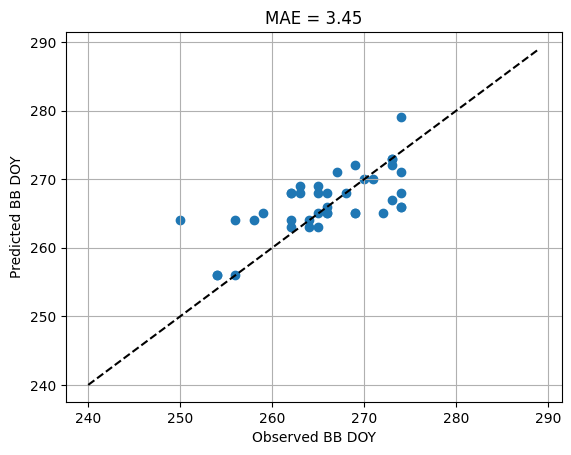

In [102]:
observations = []
predictions = []
spray_doys = []
chu_obs = []
chu_spray = []


for loc in observed_budbreak_doy.keys():
     for year in observed_budbreak_doy[loc].keys():
            for sheet_info in observed_budbreak_doy[loc][year]:
                observed_bb = observed_budbreak_doy[loc][year][sheet_info]
                observations.append(observed_bb)
                predicted_bb = predicted_budbreak_doy[loc][year][sheet_info]
                predictions.append(predicted_bb)

                spray_doys.append(observed_application_doy[loc][year][sheet_info])
                chu_obs.append(CHU_observation[loc][year][sheet_info])
                chu_spray.append(CHU_spray[loc][year][sheet_info])


mae = utils.mean_absolute_error(observations,predictions)
plt.scatter(x=observations,y=predictions)
plt.plot(np.arange(240,290,1), np.arange(240,290,1), 'k--')
plt.xlabel('Observed BB DOY')
plt.ylabel('Predicted BB DOY')
plt.title(f'MAE = {round(mae,2)}')
plt.grid()


In [95]:
residuals = np.array(predictions) - np.array(observations)

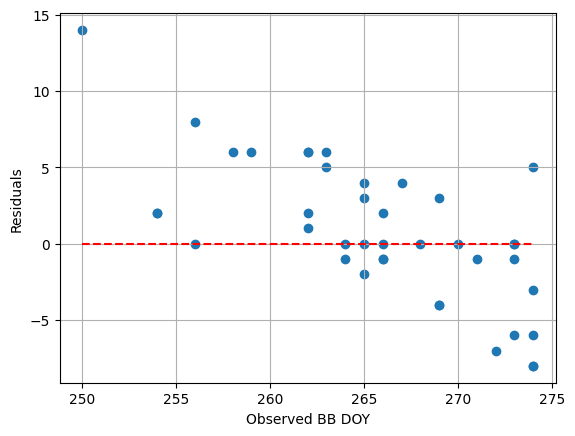

In [96]:
residuals =np.array(predictions) - np.array(observations)
plt.scatter(observations,residuals)
plt.xlabel('Observed BB DOY')
plt.ylabel('Residuals')
plt.grid()
plt.plot(np.arange(np.min(observations),np.max(observations)+1,1),np.zeros(np.max(observations)-np.min(observations)+1), 'r--', linewidth=1.5)

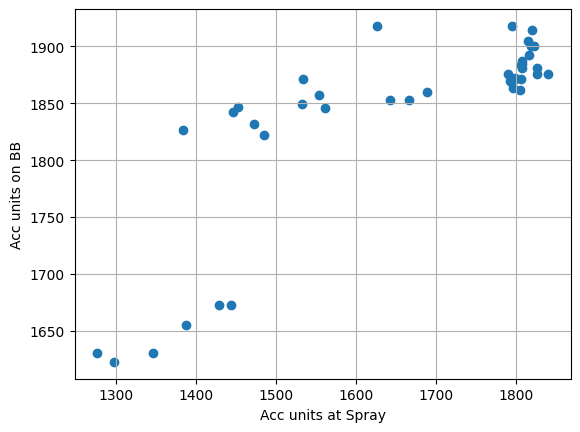

In [65]:
plt.scatter(chu_spray,chu_obs)
plt.xlabel('Acc units at Spray')
plt.ylabel('Acc units on BB')
plt.grid()

In [ ]:
observations
